In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Libraries
Importing the necessary libraries we will need to perform our forecasting analysis

In [2]:
import sys, os, pathlib, shutil, platform
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import lilliefors

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_cross_validation_metric

import plotly.express as px

# Data
This is the data we'll be working with. It is a list of the monthly freight in pounds of outbound flights from the U.S. from January 2019 to March 2022, which can be found on the publicly available dataset (https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FMG) from the Bureau of Transportation Statistics.

In [3]:
def load_datsets(years_list):
    full_path_list = ['./../../../data/paav_cargo/T-100Segment_AllCarriers/DL_SelectFields_AllMonths_AllGeo_'+
                 str(crt_year)
                 +'/T_T100_SEGMENT_ALL_CARRIER.csv' for crt_year in years_list]
    allDatasets= pd.concat([pd.read_csv(str(crt_file_name)) for crt_file_name in full_path_list], keys=years_list).reset_index()
    return allDatasets


years_list = [2019, 2020, 2021, 2022]
myData = load_datsets(years_list)

Inspect dataset

In [4]:
myData.shape
myData.head(2)
myData.tail(2)
myData.info()

(1425990, 52)

,level_0,level_1,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,...,DEST_WAC,AIRCRAFT_GROUP,AIRCRAFT_TYPE,AIRCRAFT_CONFIG,YEAR,QUARTER,MONTH,DISTANCE_GROUP,CLASS,DATA_SOURCE
0,2019,0,0.0,1.0,43400.0,200.0,157.0,0.0,0.0,92.0,...,22,6,699,1,2019,3,7,1,F,DU
1,2019,1,0.0,1.0,26200.0,100.0,100.0,0.0,0.0,145.0,...,13,6,678,1,2019,3,7,1,F,DU


,level_0,level_1,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,...,DEST_WAC,AIRCRAFT_GROUP,AIRCRAFT_TYPE,AIRCRAFT_CONFIG,YEAR,QUARTER,MONTH,DISTANCE_GROUP,CLASS,DATA_SOURCE
1425988,2022,124453,785.0,785.0,942000.0,4058.0,2179.0,8980.0,0.0,11.0,...,5,0,79,1,2022,1,3,1,F,DU
1425989,2022,124454,796.0,796.0,955200.0,4114.0,2218.0,6373.0,0.0,11.0,...,5,0,79,1,2022,1,3,1,F,DU


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425990 entries, 0 to 1425989
Data columns (total 52 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   level_0                1425990 non-null  int64  
 1   level_1                1425990 non-null  int64  
 2   DEPARTURES_SCHEDULED   1425990 non-null  float64
 3   DEPARTURES_PERFORMED   1425990 non-null  float64
 4   PAYLOAD                1425990 non-null  float64
 5   SEATS                  1425990 non-null  float64
 6   PASSENGERS             1425990 non-null  float64
 7   FREIGHT                1425990 non-null  float64
 8   MAIL                   1425990 non-null  float64
 9   DISTANCE               1425990 non-null  float64
 10  RAMP_TO_RAMP           1425990 non-null  float64
 11  AIR_TIME               1425990 non-null  float64
 12  UNIQUE_CARRIER         1425990 non-null  object 
 13  AIRLINE_ID             1425990 non-null  int64  
 14  UNIQUE_CARRIER_NAM

Aggregate data

In [5]:
mySmallData = myData.loc[myData['ORIGIN_COUNTRY_NAME'] .isin( ['United States'])]
mySmallData = mySmallData.rename({'level_0': 'OrigYEAR'}, axis=1)

Stats of relevant columns

In [6]:
mySmallData[["FREIGHT", "YEAR", "MONTH"]].describe()

,FREIGHT,YEAR,MONTH
count,1.302115e+06,1.302115e+06,1.302115e+06
mean,9.883743e+04,2.020157e+03,6.184493e+00
std,5.126057e+05,9.920491e-01,3.595767e+00
min,0.000000e+00,2.019000e+03,1.000000e+00
25%,0.000000e+00,2.019000e+03,3.000000e+00
50%,0.000000e+00,2.020000e+03,6.000000e+00
75%,2.783000e+03,2.021000e+03,9.000000e+00
max,3.731747e+07,2.022000e+03,1.200000e+01


#### Create grouping column to allow group_by month and year

In [7]:
mySmallData['FullDate'] = mySmallData['YEAR'].map(str) +"-"+ mySmallData["MONTH"].map(str) + "-01"
mySmallData['FullDate'] = pd.to_datetime(mySmallData['FullDate'],format='%Y-%m-%d')

Use aggregation to compute forecasting data

In [8]:
data_column='FREIGHT'
geoAggColumn = 'ORIGIN_COUNTRY_NAME'

regressionData = mySmallData.groupby([geoAggColumn,'FullDate'])[data_column].sum().reset_index()

regressionData.sort_values(by=['FullDate'], ascending=True, inplace=True)
regressionData

,ORIGIN_COUNTRY_NAME,FullDate,FREIGHT
0,United States,2019-01-01,3.008939e+09
1,United States,2019-02-01,2.690377e+09
2,United States,2019-03-01,3.196169e+09
3,United States,2019-04-01,3.008646e+09
4,United States,2019-05-01,3.189460e+09
5,United States,2019-06-01,3.074642e+09
6,United States,2019-07-01,3.081732e+09
7,United States,2019-08-01,3.200322e+09
8,United States,2019-09-01,2.954616e+09
9,United States,2019-10-01,3.268399e+09


Make date column an index for easier plotting and processing

In [9]:
regressionData.index = pd.to_datetime(regressionData['FullDate'],format='%Y-%m-%d')
regressionData.drop(columns=['FullDate', geoAggColumn],inplace=True)
regressionData.sort_index(inplace=True)

In [10]:
regressionData.head(2)

,FREIGHT
FullDate,
2019-01-01,3.008939e+09
2019-02-01,2.690377e+09


### See trends, seasonality (using statsmodels.tsa.seasonal import seasonal_decompose)
The goal of the remaining of this notebook is to show manually how these results are computed.

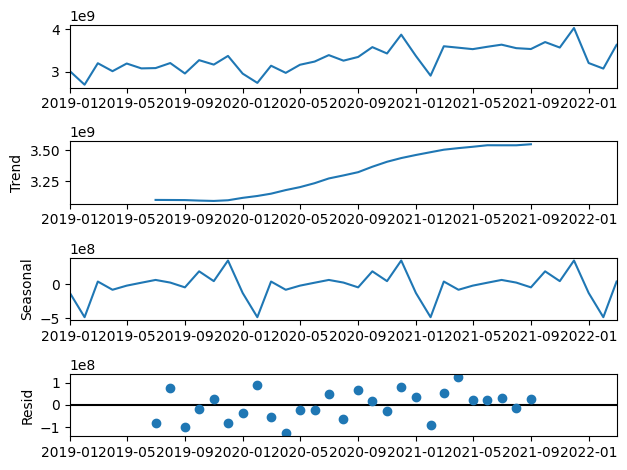

In [11]:
decompose_data = seasonal_decompose(regressionData, model="additive")
decompose_data.plot();

In [12]:
# reglist = [3008938540.0, 2690376773.0, 3196168600.0, 3008646242.0, 3189460227.0, 3074642494.0, 3081731655.0, 3200322417.0, 2954616071.0, 3268398931.0, 3163838579.0, 3368554913.0, 2951273149.0, 2733092446.0, 3137388328.0, 2969226190.0, 3160010320.0, 3235408582.0, 3387474351.0, 3256920093.0, 3344153676.0, 3575603405.0, 3426098618.0, 3869472981.0, 3367168591.0, 2903368434.0, 3596389801.0, 3561978142.0, 3528241426.0, 3584197736.0, 3633613132.0, 3551634185.0, 3531001949.0, 3695020217.0, 3565951096.0, 4026504978.0, 3201106628.0, 3070168505.0, 3629533034.0]

reglist = regressionData['FREIGHT'].values.tolist()
reglist[:5]


[3008938540.0, 2690376773.0, 3196168600.0, 3008646242.0, 3189460227.0]

# Trend
The first step is to calculate the trend of our regression data. Trend is the collection of averages of the sliding window of size seasonality_length of your regression data. 
Here, we use seasonality_length = 12 because we have monthly data and want to calculate the yearly seasonality.

In [13]:
seasonality_length = 12

We will need to match up each average with a date. It's your choice which date you choose to use to correspond to the average, but it's typical to use the one at the (seasonality_length)/2 position when seasonality_length is even (when seasonality_length is odd, the (seasonality_length+1)/2 position is typically assigned to the average across the seasonality_length numbers). You'll see this soon.

This is the work that will output a list of the collection of averages. It is based off the intuitive formula that: x + seasonality_length - 1 = t, where: x is the number of sliding window groups of size seasonality_length; seasonality_length is the number of elements per sliding window group, and t is the total amount of elements you have from which you want to create sliding window groups of size seasonality_length. Of course, seasonality_length and t are parameters that we use to find x.


In [14]:
def compute_trend(time_series_data_values, seasonality_length):
    trend_length = len(time_series_data_values)-seasonality_length+1
    trend = []
    for crtgroup in range(trend_length):
        crtavg = sum(time_series_data_values[:seasonality_length]) / seasonality_length
        trend.append(crtavg)
        time_series_data_values.pop(0)
    return trend
  
trend = compute_trend(reglist.copy(), seasonality_length)    
print(trend)
print(len(trend))
print(reglist)

[3100474620.1666665, 3095669170.9166665, 3099228810.3333335, 3094330454.3333335, 3091045450.0, 3088591291.0833335, 3101988465.0833335, 3127467023.0833335, 3132183496.0833335, 3164644963.1666665, 3190245336.0, 3212100339.25, 3253843511.5833335, 3288501465.0833335, 3302691130.75, 3340941253.5, 3390337249.5, 3421023175.0, 3450088937.8333335, 3470600502.9166665, 3495160010.5833335, 3510730700.0, 3520682101.0, 3532336474.1666665, 3545422473.9166665, 3531583977.0, 3545483982.9166665, 3548245919.0]
28
[3008938540.0, 2690376773.0, 3196168600.0, 3008646242.0, 3189460227.0, 3074642494.0, 3081731655.0, 3200322417.0, 2954616071.0, 3268398931.0, 3163838579.0, 3368554913.0, 2951273149.0, 2733092446.0, 3137388328.0, 2969226190.0, 3160010320.0, 3235408582.0, 3387474351.0, 3256920093.0, 3344153676.0, 3575603405.0, 3426098618.0, 3869472981.0, 3367168591.0, 2903368434.0, 3596389801.0, 3561978142.0, 3528241426.0, 3584197736.0, 3633613132.0, 3551634185.0, 3531001949.0, 3695020217.0, 3565951096.0, 402650497

Great! You have just completed the first part to your forecast analysis. To reiterate, this list printed above is the collection of sliding window averages of size 12 of our freight values. Trend is a pretty good summary of the behavior of your data, and we'll see in the following section how it will help us in finding a second breakdown/ component of our data: seasonality.

# Seasonality
### Detrend
Before we calculate the seasonality of the data, we first need to detrend the data. Why? Imagine that our freight values constantly grew over time. If we were to look at it raw, it would be very difficult to identify when there is a dip or incline of values because the data is just rising upwards. Detrending levels the data out, and allows us to identify patterns more clearly.

We detrend data by subtracting the trend from the data, which means we subtract each average in the trend list from its corresponding (by index) data value from the regression data. There's just one problem... there is a different amount of  elements in the trend list than in our regression list, reglist. Specifically, we have 39 data values, but only 28 averages. So, 11 data values will have no average that can be subtracted from them. Generally, we have t data values, but only x, or t-seasonality_length+1, averages. So, t-(t-seasonality_length+1) = seasonality_length-1 data values will have no average that can be subtracted from them.

A simplistic approach is to "create" averages for the seasonality_length-1 values we need by reusing the first and last average in our trend list. A more complicated way to fix this, but more precise way, is by looking at the graph of the trend and extrapolating its behavior to cover the entire range of time values. We will focus on the former. Let's start!

In [15]:
if (seasonality_length % 2) == 0: #even seasonality_length
    numdatestofillatstart = math.floor(seasonality_length/2) -1
    numdatestofillatend = math.floor(seasonality_length/2) 
else: #seasonality_length is odd
    numdatestofillatstart = math.floor((seasonality_length-1)/2) 
    numdatestofillatend = math.floor((seasonality_length-1)/2) 

#numdatestofillatstart and numdatestofillatend should be 5 and 6 respectively when seasonality_length = 12    
assert (5==numdatestofillatstart)
assert (6==numdatestofillatend)

Quick interruption: remember we said that we will need to match up each average with a date? That's what the above cell is taking care of! As mentioned, it's your choice which date you choose to use to correspond to the average, but it's typical to use the one at the (seasonality_length)/2 position when seasonality_length is even. When seasonality_length is odd, the (seasonality_length+1)/2 position is typically assigned to the average across the seasonality_length numbers. Based off of these is how I chose these values. Again, seasonality_length is 12.

In [16]:
extendedtrend = trend.copy()
extendedtrend = [trend[0]] * numdatestofillatstart + extendedtrend
extendedtrend = extendedtrend+ [trend[-1]] * numdatestofillatend

print(trend)
print(extendedtrend)


[3100474620.1666665, 3095669170.9166665, 3099228810.3333335, 3094330454.3333335, 3091045450.0, 3088591291.0833335, 3101988465.0833335, 3127467023.0833335, 3132183496.0833335, 3164644963.1666665, 3190245336.0, 3212100339.25, 3253843511.5833335, 3288501465.0833335, 3302691130.75, 3340941253.5, 3390337249.5, 3421023175.0, 3450088937.8333335, 3470600502.9166665, 3495160010.5833335, 3510730700.0, 3520682101.0, 3532336474.1666665, 3545422473.9166665, 3531583977.0, 3545483982.9166665, 3548245919.0]
[3100474620.1666665, 3100474620.1666665, 3100474620.1666665, 3100474620.1666665, 3100474620.1666665, 3100474620.1666665, 3095669170.9166665, 3099228810.3333335, 3094330454.3333335, 3091045450.0, 3088591291.0833335, 3101988465.0833335, 3127467023.0833335, 3132183496.0833335, 3164644963.1666665, 3190245336.0, 3212100339.25, 3253843511.5833335, 3288501465.0833335, 3302691130.75, 3340941253.5, 3390337249.5, 3421023175.0, 3450088937.8333335, 3470600502.9166665, 3495160010.5833335, 3510730700.0, 35206821

#### Putting together results so far:
Plot the computed trend

(array([17897., 18017., 18140., 18262., 18383., 18506., 18628., 18748.,
        18871., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

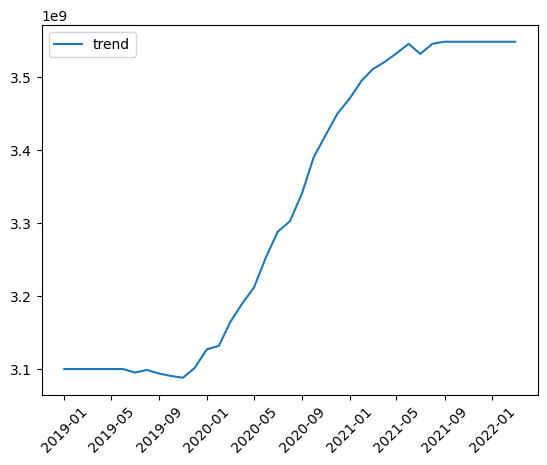

In [17]:
x_list = list(regressionData.index.values)
plt.plot(x_list, extendedtrend, label='trend')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

Now that we have a list of averages that has the same number of elements as our regression data, aka we created a complete list of trends, we can detrend the data! This is important because it will allow us to more clearly see subtrends in the data that are seasonal or cyclical. Imagine our data had an upward trend...it would be pretty difficult to figure out which months are dips or not. Detrending the data levels it out. Remember, we do this by subtracting the trend from the data, which means we subtract each average in the (extended)trend list from its corresponding (by index) data value from the regression data. 

In [18]:
detrended = [element1 - element2 for (element1, element2) in zip(reglist, extendedtrend)]

print(detrended)
print(len(detrended))   

[-91536080.16666651, -410097847.1666665, 95693979.83333349, -91828378.16666651, 88985606.83333349, -25832126.166666508, -13937515.916666508, 101093606.66666651, -139714383.3333335, 177353481.0, 75247287.91666651, 266566447.9166665, -176193874.0833335, -399091050.0833335, -27256635.166666508, -221019146.0, -52090019.25, -18434929.583333492, 98972885.91666651, -45771037.75, 3212422.5, 185266155.5, 5075443.0, 419384043.1666665, -103431911.91666651, -591791576.5833335, 85659101.0, 41296041.0, -4095048.1666665077, 38775262.08333349, 102029155.0, 6150202.083333492, -17243970.0, 146774298.0, 17705177.0, 478259059.0, -347139291.0, -478077414.0, 81287115.0]
39


#### Putting together results so far:
Plot observed data, computed trend, and detrended data

(array([17897., 18017., 18140., 18262., 18383., 18506., 18628., 18748.,
        18871., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

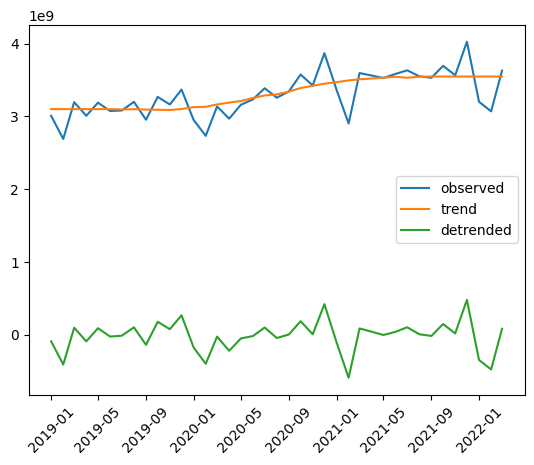

In [19]:
plt.plot(x_list, reglist, label='observed')
plt.plot(x_list, extendedtrend, label='trend')
plt.plot(x_list, detrended, label='detrended')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

### Actually Finding Seasonality
Great! We are now ready to find the seasonality of the data, which depends on the detrended data and seasonality_length to produce seasonality_length values which will be the average of, in our case with monthly data, each month across all years



In [20]:
def grouptogether(yourlist, step):
    return [yourlist[index::step] for index in range(step)]
seasonalitygroupings = grouptogether(detrended, seasonality_length)
# print(seasonalitygroupings)

seasonality = [sum(crtmonth) / seasonality_length for crtmonth in seasonalitygroupings]
print(seasonality)
# print(len(seasonality))

[-59858429.76388887, -156588157.31944445, 19615296.72222225, -22629290.263888877, 2733378.2847222486, -457649.472222209, 15588710.416666666, 5122730.916666667, -12812160.902777791, 42449494.541666664, 8168992.326388876, 97017462.50694442]


#### Putting together results so far:
Print seasonality computed for the first __seasonality_length__ time points

(array([17897., 17956., 18017., 18078., 18140., 18201.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

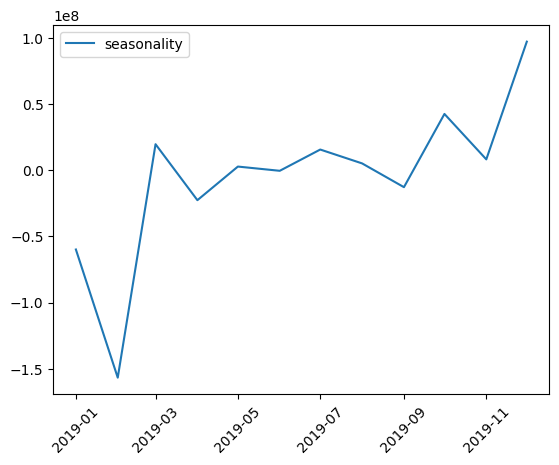

In [21]:
plt.plot(x_list[:seasonality_length], seasonality, label='seasonality')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

# Residuals
In order to see how well trend and seasonality describe our data, we look at the residuals. Roughly, trend added to seasonality should reproduce our data. These values, 
typically called reconstructed data, subtracted from our original regression data will give us the residuals that we need to examine. We'll get into *how* we need to examine them later. For now, let's focus on obtaining them.

In [22]:
# [(i,i%seasonality_length) for i in range(len(extendedtrend))]

In [23]:
reconstructeddata = [extendedtrend[i] + seasonality[i%seasonality_length] for i in range(len(extendedtrend))]
print(reconstructeddata)

residuals = [reglist[i] - reconstructeddata[i] for i in range(len(reglist))]
print(residuals)

[3040616190.4027777, 2943886462.847222, 3120089916.888889, 3077845329.9027777, 3103207998.451389, 3100016970.694444, 3111257881.333333, 3104351541.25, 3081518293.430556, 3133494944.5416665, 3096760283.4097223, 3199005927.5902777, 3067608593.3194447, 2975595338.763889, 3184260259.888889, 3167616045.736111, 3214833717.5347223, 3253385862.111111, 3304090175.5, 3307813861.6666665, 3328129092.5972223, 3432786744.0416665, 3429192167.326389, 3547106400.3402777, 3410742073.1527777, 3338571853.263889, 3530345996.7222223, 3498052810.736111, 3535069852.451389, 3544964824.444444, 3547172687.4166665, 3550606713.833333, 3535433758.0972223, 3590695413.5416665, 3556414911.326389, 3645263381.5069447, 3488387489.236111, 3391657761.6805553, 3567861215.7222223]
[-31677650.40277767, -253509689.84722185, 76078683.11111116, -69199087.90277767, 86252228.54861116, -25374476.69444418, -29526226.333333015, 95970875.75, -126902222.43055582, 134903986.4583335, 67078295.59027767, 169548985.40972233, -116335444.3194

#### Putting together results so far:
Plot the residuals

(array([17897., 18017., 18140., 18262., 18383., 18506., 18628., 18748.,
        18871., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

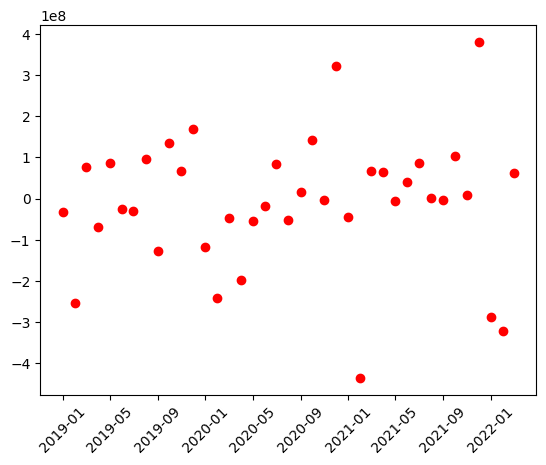

In [24]:
plt.scatter(x_list, residuals, c ="red")
plt.xticks(rotation = 45)
plt.show()

We found the residuals! Now it's time to investigate them. We will assess their distribution by residual histogram.
We hope that the residual histogram will look relatively Normal, but we are already on a good track based on the residual plot which shows the residuals randomly scattered about 0. It indicates that there is no leftover pattern in them, as in the computed seasonality and trend accurately models the data, and all that's left behind is natural error. If our computations missed something in the data, then the residual histogram might have a different shape (like skewed or bimodal) and our residual plot may have direction, shape, be not spread horizontally, have different amount of scatter/ variance throughout, have bends, and/or have outliers. These will indicate that our computations are not a good fit for the data.

Let's do it!

(array([ 1.,  2.,  3.,  2.,  7.,  9., 11.,  2.,  0.,  2.]),
 array([-4.35203419e+08, -3.53558918e+08, -2.71914416e+08, -1.90269915e+08,
        -1.08625413e+08, -2.69809114e+07,  5.46635902e+07,  1.36308092e+08,
         2.17952593e+08,  2.99597095e+08,  3.81241596e+08]),
 <BarContainer object of 10 artists>)

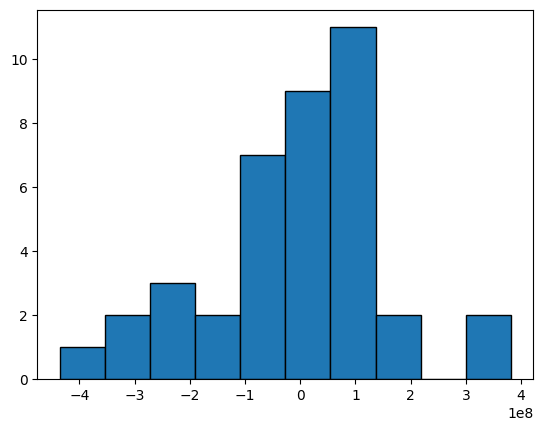

In [25]:
#1: residual histogram
plt.hist(residuals, edgecolor='black', bins=10)

Good: this looks more or less normal, although there does seem to be a slight skew to the left.

# Residuals II
We should quantify this normality, though. Let's perform a normality check on the residuals formally with a popular test: Kolmogorov-Smirnov Test, otherwise known as KS test. It measures how well the distribution of sample data conforms to some theoretical distribution (for us, that is the Normal Distribution). Conformity is quantified by test statistic D: the greatest difference between the theoretical cumulative distribution function (cdf) and sample data cdf. 

This is not a typical hypothesis test because by KS definition, the KS null hypothesis is that the data comes from the specified, theoretical distribution with the alternative hypothesis that the population cdf is not the assumed theoretical distribution. We compare the theoretical distribition (as mentioned, Normal) against the standardized (z-scores) distribution of the residuals.

It's simple to do manually, but it's easier to use the kstest from the stats package from scipy library. 

In [26]:
stats.kstest(stats.zscore(residuals), stats.norm.cdf)

KstestResult(statistic=0.15504424480277018, pvalue=0.27599234367304937)

With a pvalue this large, we will fail to reject the null. As discussed, the test is backward with the hypotheses, so it's tempting to feel disappointed in seemingly not having a high enough p-value (in order to "accept" the null). 

However, below, you can get a feeling about what's a reasonable range for this pvalue when you should not reject the null (as in, when the sample data do indeed come from a Normal Distribution).

In [27]:
for simulation_counts in range(10):
    print(stats.kstest(stats.norm.rvs(size=len(residuals), random_state=np.random.default_rng()), stats.norm.cdf))

KstestResult(statistic=0.12065505273501742, pvalue=0.5795167310657076)
KstestResult(statistic=0.16947780724257688, pvalue=0.18953795789948835)
KstestResult(statistic=0.06875660771607095, pvalue=0.9866192540762598)
KstestResult(statistic=0.10619091286252524, pvalue=0.7316180432255666)
KstestResult(statistic=0.15047924343981084, pvalue=0.30851958586426753)
KstestResult(statistic=0.10418987004730973, pvalue=0.7521409800306449)
KstestResult(statistic=0.17151870891024168, pvalue=0.179222801245688)
KstestResult(statistic=0.18787986617685226, pvalue=0.1116279656509066)
KstestResult(statistic=0.21549503598527686, pvalue=0.04543267946882357)
KstestResult(statistic=0.1868186103790842, pvalue=0.11526306170287604)


"Keeping" the null with this pvalue (0.276) is not bad considering this large range of pvalues seen above when you actually know that the sample does indeed come from a Normal population.

#### Manual forecasting analysis results:
Plot __observed data__, __trend__, __detrended data__, __reconstructeddata__, and __residuals__

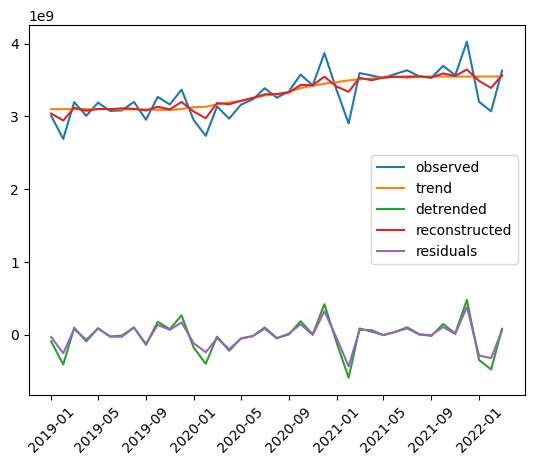

In [28]:
_ = plt.plot(x_list, reglist, label='observed')
_ = plt.plot(x_list, extendedtrend, label='trend')
_ = plt.plot(x_list, detrended, label='detrended')
_ = plt.plot(x_list, reconstructeddata, label='reconstructed')
_ = plt.plot(x_list, residuals, label='residuals')
_ = plt.xticks(rotation = 45)
_ = plt.legend()
plt.show()

(-1000000000.0, 1000000000.0)

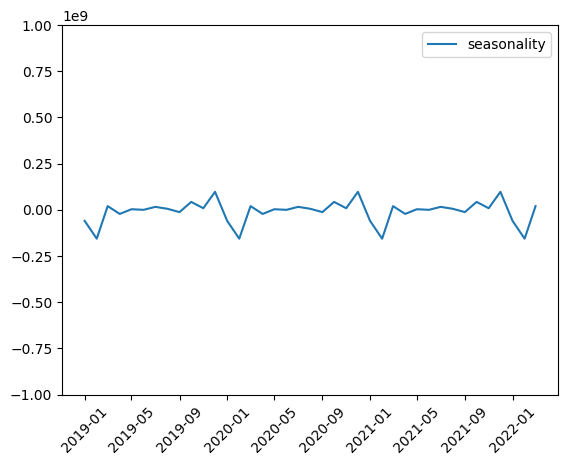

In [29]:
allseasonality = seasonality * math.ceil((len(reglist)/seasonality_length))
allseasonality = allseasonality[:len(reglist)]
_ = plt.plot(x_list, allseasonality, label='seasonality')
_ = plt.xticks(rotation = 45)
_ = plt.legend()
plt.ylim(-1e9, 1e9)
plt.show()

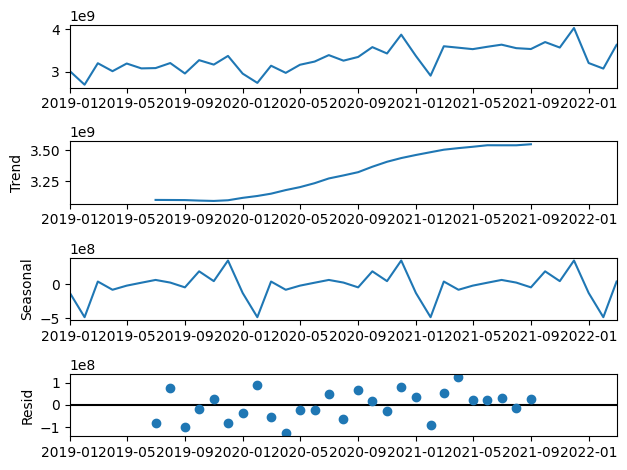

In [30]:
decompose_data = seasonal_decompose(regressionData, model="additive")
decompose_data.plot();

In this notebook we demystified how forecasting works. Forecasting is an important machine learning tool, and hopefully what you learned here weill help you conduct forecasting analysis in the future on your own data. Happy forecasting!